In [1]:
#main libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#vectorizors
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [3]:
#store values in pickles 
from sklearn.externals import joblib

In [4]:
#performence metrics
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [5]:
#modules for building ML model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

## Objective

1. Train, CV, Test split.

2. build Random Forest and XGboost GBDT

3. RF - n_estimators, XGBOOST = n_estimators, max-depth.

## Constraints

1. Decision Tree doesn't work well on BOW, TFIDF, also it takes too much time because of dimensionality problem

2. these are solved in AVGW2V, TFIDFW2V where dimensionallity is small.

3. only 100k points are used.

In [6]:
#connect sql database
con = sqlite3.connect('final.sqlite')

In [7]:
#read sql data using pandas
data = pd.read_sql("SELECT * FROM REVIEWS", con)

In [8]:
def partition(x) :
    if x == 'positive' :
        return 1
    return 0

actualscore = data['Score']
positivenegative = actualscore.map(partition)
data['Score'] = positivenegative

In [9]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


Number of positive & negative data points are 
 1    307061
0     57110
Name: Score, dtype: int64


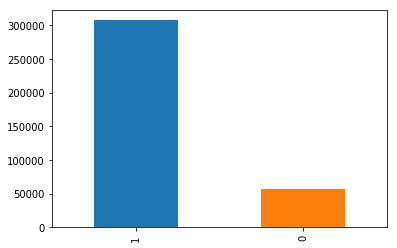

In [10]:
print ('Number of positive & negative data points are \n',data['Score'].value_counts())
data['Score'].value_counts().plot(kind='bar')

In [11]:
#sort data based on time
df_time_sorted = data.sort_values('Time', kind ='quicksort')

In [12]:
df_time_sorted.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


The important piece of information from dataset for building ML models are text reviews and their Scores if they are positive or negative so lets seperate only those two columns into a seperate dataframe using pandas

In [13]:
df = pd.DataFrame(data, columns=['CleanedText', 'Score'])
df.head()

,CleanedText,Score
0,witti littl book make son laugh loud recit car...,1
1,grew read sendak book watch realli rosi movi i...,1
2,fun way children learn month year learn poem t...,1
3,great littl book read nice rhythm well good re...,1
4,book poetri month year goe month cute littl po...,1


In [14]:
#lets check the total dataset values
df.shape

(364171, 2)

Number of +ve & -ve datapoints 
 1    85197
0    14803
Name: Score, dtype: int64


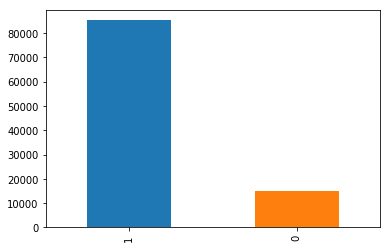

In [15]:
df_sample = df.head(100000)
print ('Number of +ve & -ve datapoints \n' ,df_sample['Score'].value_counts())
df_sample['Score'].value_counts().plot(kind='bar')

In [16]:
X = df_sample['CleanedText']
y = df_sample['Score']
print (X.shape)
print (y.shape)

(100000,)
(100000,)


In [17]:
#test-train-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=False)
print('X_train shape :' ,X_train.shape)
print('y_train shape :' ,y_train.shape)
print('X_test shape :' ,X_test.shape)
print('y_test shape :' ,y_test.shape)

X_train shape : (70000,)
y_train shape : (70000,)
X_test shape : (30000,)
y_test shape : (30000,)


In [18]:
joblib.dump(X_train, 'X_train.pkl') 
joblib.dump(X_test, 'X_test.pkl') 
joblib.dump(X_train, 'y_train.pkl') 
joblib.dump(X_test, 'y_test.pkl') 

['y_test.pkl']

In [15]:
X_train = joblib.load('X_train.pkl') 
X_test = joblib.load('X_test.pkl') 
y_train = joblib.load('y_train.pkl') 
y_test = joblib.load('y_test.pkl') 

### check if rows are not shuffled since its time series data

In [18]:
X_train.head()

0    witti littl book make son laugh loud recit car...
1    grew read sendak book watch realli rosi movi i...
2    fun way children learn month year learn poem t...
3    great littl book read nice rhythm well good re...
4    book poetri month year goe month cute littl po...
Name: CleanedText, dtype: object

In [19]:
X_test.head()

70000    introduc madhava agav sister back jan diabet r...
70001    love nectar wish amazon would quit rais price ...
70002    purchas particular item twice price local heal...
70003    madhava agav nectar low calori natur kosher sw...
70004    bought replac honey tendenc crystal winter mon...
Name: CleanedText, dtype: object

In [20]:
X_train.tail()

69995    madhava agav nectar amber bottl pack use agav ...
69996    forget aspartam artifici sweetner agav nectar ...
69997    ferment agav nectar realli refresh drink twist...
69998    love stuff liquid dissolv easier low gci proba...
69999    start eat healthier one ago biggest step chang...
Name: CleanedText, dtype: object

In [21]:
X_test.tail()

99995    delici sugar pretti light brown color delici a...
99996    sugar raw flavor profil much better white suga...
99997    use buy sugar year eat much sugar still sugar ...
99998    product exact advertis save least half retail ...
99999    love sugar also get muscavado sugar great use ...
Name: CleanedText, dtype: object

# Functions to find Hyperparameter & Use GBDT & RF

### Functions for Ensemble Bagging Random forest

In [93]:
def RF_best_params (X_train, y_train) :
    clf = RandomForestClassifier(n_jobs=-1)
    param_grid = {'n_estimators' : list(range(10,100)), 'max_depth' : list(range(1,50))}
    cv = TimeSeriesSplit(n_splits=10)
    rand_cv = RandomizedSearchCV(clf, param_grid, cv=cv, verbose=1, n_jobs=-1, random_state=42)
    rand_cv.fit(X_train,y_train)
    print('best Accuracy:', rand_cv.best_params_)
    print('best Score:', rand_cv.best_score_)
    #accessing cv_results
    cv_results = pd.DataFrame(rand_cv.cv_results_)
    plot_data_1 = cv_results[['param_n_estimators', 'mean_test_score']].sort_values('param_n_estimators')
    #Function for cv_error vs alpha plot
    plt.figure(figsize=(10,6))
    plt.xlabel('Hyperparams')
    plt.ylabel('Best Score')
    plt.plot(plot_data_1['param_n_estimators'], plot_data_1['mean_test_score'], marker='o', markerfacecolor='green', markersize=10, label='n_estimators')
    plt.legend(loc='upper left')

In [94]:
def RF(n_estimators, max_depth, X_train, y_train, X_test, y_test) :
    clf = RandomForestClassifier(n_estimators = n_estimators , max_depth = max_depth, n_jobs=-1)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print('accuracy:',accuracy_score(y_test,y_pred))
    print('f1_score:',f1_score(y_test,y_pred))
    print('precision_score =', precision_score(y_test, y_pred))
    print('recall_score =', recall_score(y_test, y_pred))
    cm = confusion_matrix(y_test,y_pred)
    print("Confusion Matrix:")
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

### Functions for Ensemble Boosting using XGBOOST

In [95]:
def XGB_best_params (X_train, y_train) :
    clf = XGBClassifier(n_jobs = -1)
    param_grid = {'learning_rate' : np.linspace(0,1,6),
                  'n_estimators' : [10, 30, 50, 100, 200],
                  'max_depth' : list(range(1,7))}
    cv = TimeSeriesSplit(n_splits=10)
    rand_cv = RandomizedSearchCV(clf, param_grid, verbose=1, cv=cv, n_jobs=-1)
    rand_cv.fit(X_train, y_train)
    print('best Accuracy:', rand_cv.best_params_)
    print('best Score:', rand_cv.best_score_)
    #accessing cv_results
    cv_results = pd.DataFrame(rand_cv.cv_results_)
    plot_data_1 = cv_results[['param_n_estimators', 'mean_test_score']].sort_values('param_n_estimators')
    #Function for cv_error vs alpha plot
    plt.figure(figsize=(10,6))
    plt.xlabel('Hyperparams')
    plt.ylabel('Best Score')
    plt.plot(plot_data_1['param_n_estimators'], plot_data_1['mean_test_score'], marker='o', markerfacecolor='green', markersize=10, label='n_estimators')
    plt.legend(loc='upper left')

In [110]:
def XGB(learning_rate, n_estimators, max_depth, X_train, y_train, X_test, y_test) :
    clf = XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth , njobs=-1)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print('accuracy Score =', accuracy_score(y_test, y_pred))
    print('F1 Score =', f1_score(y_test, y_pred))
    print('precision_score =', precision_score(y_test, y_pred))
    print('recall_score =', recall_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

# WORD2VECTOR Model

**AVGW2V & TFIDFW2V takes lot of time to train so we use only first 25k data**

In [24]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

In [25]:
print(X_train.values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [26]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [29]:
joblib.dump(w2v_model, 'w2v.pkl')

['w2v.pkl']

In [22]:
w2v_model = joblib.load('w2v.pkl')

In [27]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10848
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'rosi', 'movi', 'incorpor', 'howev', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsi', 'take', 'two', 'hand']


# AVGW2V

### AVGW2V on train data

In [28]:

# average Word2Vec
# compute average word2vec for each review.
%time train_vectors = []; # the avg-w2v for each sentence/review is stored in this li
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
print(len(train_vectors))
print(len(train_vectors[0]))

Wall time: 0 ns
70000
50


In [29]:
avgw2v_train = preprocessing.normalize(train_vectors)

### AVGW2V on test data

In [30]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_in_test=[]
for sent in X_test.values:
    list_of_sent_in_test.append(sent.split())

In [31]:
print(X_test.values[0])
print("*****************************************************************")
print(list_of_sent_in_test[0])

introduc madhava agav sister back jan diabet run famili decid use tea coffe cereal cold hot pass friend famili found also enjoy benefit tast doesnt take much make thing sweet high recommend anyon children well amazon best price
*****************************************************************
['introduc', 'madhava', 'agav', 'sister', 'back', 'jan', 'diabet', 'run', 'famili', 'decid', 'use', 'tea', 'coffe', 'cereal', 'cold', 'hot', 'pass', 'friend', 'famili', 'found', 'also', 'enjoy', 'benefit', 'tast', 'doesnt', 'take', 'much', 'make', 'thing', 'sweet', 'high', 'recommend', 'anyon', 'children', 'well', 'amazon', 'best', 'price']


In [32]:
# average Word2Vec
# compute average word2vec for each review.
test_vectors = []; # the avg-w2v for each sentence/review is stored in this list

for sent in list_of_sent_in_test : # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))
print(len(test_vectors[0]))

30000
50


In [33]:
avgw2v_test = preprocessing.normalize(test_vectors)

In [36]:
joblib.dump(avgw2v_train, 'avgw2v_train.pkl') 
joblib.dump(avgw2v_test, 'avgw2v_test.pkl') 

['avgw2v_test.pkl']

In [24]:
avgw2v_train = joblib.load('avgw2v_train.pkl') 
avgw2v_test = joblib.load('avgw2v_test.pkl') 

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished


best Accuracy: {'n_estimators': 42, 'max_depth': 35}
best Score: 0.8841426999842842


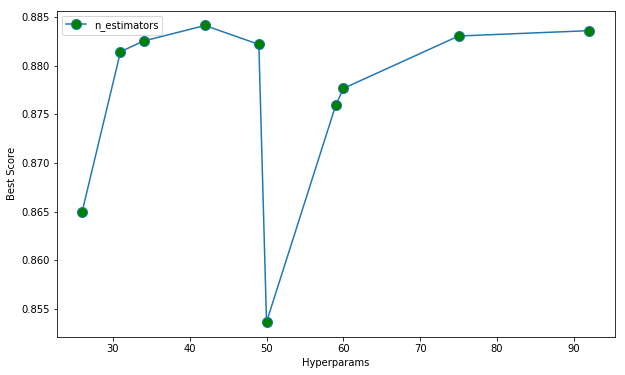

In [97]:
RF_best_params(avgw2v_train, y_train)

accuracy: 0.8869666666666667
f1_score: 0.9367433357583898
precision_score = 0.8953712288709792
recall_score = 0.9821239976530413
Confusion Matrix:


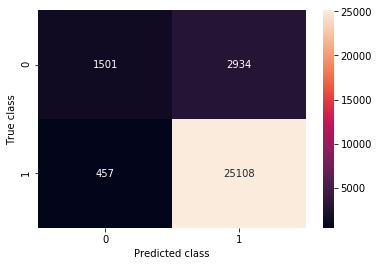

In [98]:
RF(42, 35, avgw2v_train, y_train, avgw2v_test, y_test)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.3min finished


best Accuracy: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2}
best Score: 0.8935093509350935


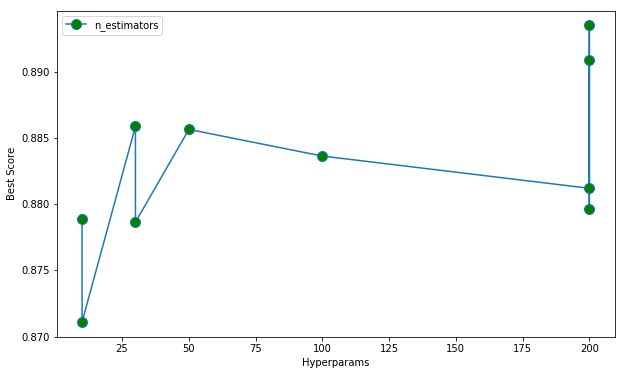

In [99]:
XGB_best_params(avgw2v_train, y_train)

accuracy Score = 0.8968666666666667
F1 Score = 0.9412568824757926
precision_score = 0.91451761667589
recall_score = 0.9696068844122824


C:\Users\Aravindh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


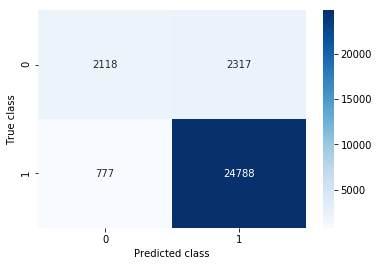

In [111]:
XGB(0.2,200, 3, avgw2v_train, y_train, avgw2v_test, y_test)

# TFIDFW2V

### TFIDFW2V on Train data

In [101]:
#calculate TFIDF
tf_idf_vect = TfidfVectorizer()
final_tf_idf_train = tf_idf_vect.fit_transform(X_train.values)
final_tf_idf_test = tf_idf_vect.transform(X_test.values)

In [102]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
np.seterr(divide='ignore', invalid='ignore')
tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_train[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
print(len(tfidf_train_vectors))
print(len(tfidf_train_vectors[0]))

70000
50


In [103]:
tfidfw2v_train = preprocessing.normalize(tfidf_train_vectors)
#tfidfw2v_train = tfidf_train_vectors

### TFIDFW2V on Test Data

In [104]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
np.seterr(divide='ignore', invalid='ignore')
tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_in_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_test[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1
print(len(tfidf_test_vectors))
print(len(tfidf_test_vectors[0]))


30000
50


In [105]:
tfidfw2v_test = preprocessing.normalize(tfidf_test_vectors)
tfidfw2v_test.shape

(30000, 50)

In [45]:
joblib.dump(tfidfw2v_train, 'tfidfw2v_train.pkl') 
joblib.dump(tfidfw2v_test, 'tfidfw2v_test.pkl') 

['tfidfw2v_test.pkl']

In [46]:
tfidfw2v_train = joblib.load('tfidfw2v_train.pkl') 
tfidfw2v_test = joblib.load('tfidfw2v_test.pkl') 

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished


best Accuracy: {'n_estimators': 92, 'max_depth': 42}
best Score: 0.8754518308973754


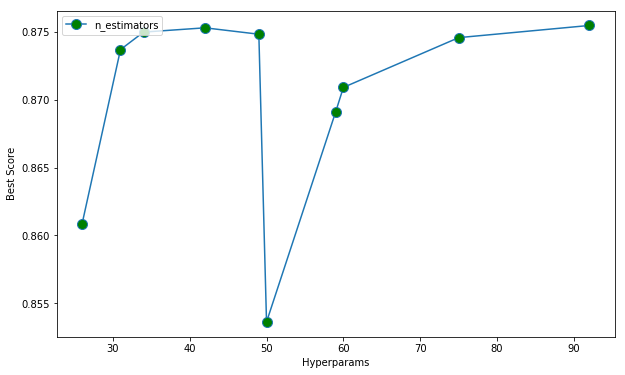

In [106]:
RF_best_params(tfidfw2v_train, y_train)

accuracy: 0.8810666666666667
f1_score: 0.93391858354632
precision_score = 0.8868760772450667
recall_score = 0.9862311754351653
Confusion Matrix:


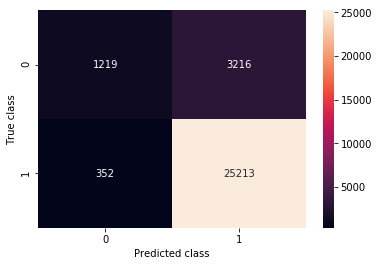

In [107]:
RF(92, 42, tfidfw2v_train, y_train, tfidfw2v_test, y_test)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished


best Accuracy: {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.6000000000000001}
best Score: 0.8775420399182775


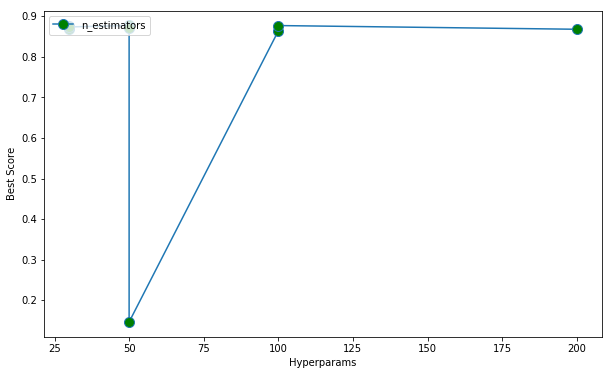

In [108]:
XGB_best_params(tfidfw2v_train, y_train)

accuracy Score = 0.8815
F1 Score = 0.9331477894578484
precision_score = 0.8985585977111401
recall_score = 0.970506551926462


C:\Users\Aravindh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


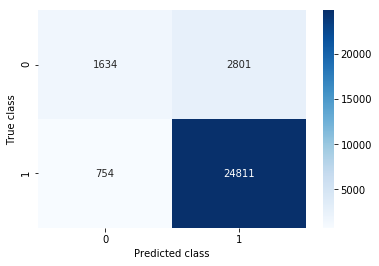

In [112]:
XGB(0.6, 50, 2, tfidfw2v_train, y_train, tfidfw2v_test, y_test)

# BAG of WORDS

In [113]:
vect = CountVectorizer()

In [114]:
bow_X_train = vect.fit_transform(X_train)
bow_X_train = preprocessing.normalize(bow_X_train)
bow_X_train

<70000x32149 sparse matrix of type '<class 'numpy.float64'>'
	with 2162199 stored elements in Compressed Sparse Row format>

In [115]:
bow_X_test = vect.transform(X_test)
bow_X_test = preprocessing.normalize(bow_X_test)
bow_X_test

<30000x32149 sparse matrix of type '<class 'numpy.float64'>'
	with 880827 stored elements in Compressed Sparse Row format>

In [ ]:
joblib.dump(bow_X_train, 'bow_X_train.pkl') 
joblib.dump(bow_X_test, 'bow_X_test.pkl') 

In [ ]:
bow_X_train = joblib.load('bow_X_train.pkl') 
bow_X_test = joblib.load('bow_X_test.pkl') 

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished


best Accuracy: {'n_estimators': 92, 'max_depth': 42}
best Score: 0.8557127141285558


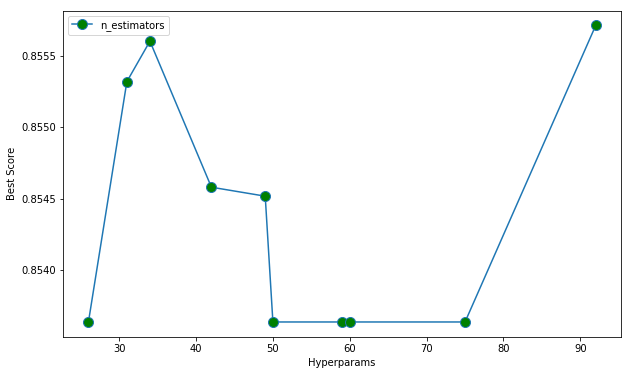

In [116]:
RF_best_params(bow_X_train, y_train)

accuracy: 0.8539
f1_score: 0.9210455208689856
precision_score = 0.8536463202885001
recall_score = 1.0
Confusion Matrix:


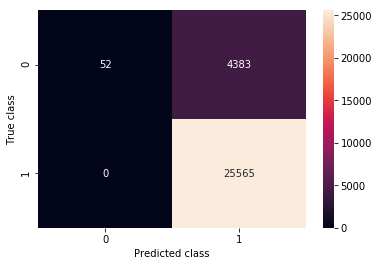

In [117]:
RF(92, 42, bow_X_train, y_train, bow_X_test, y_test)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


best Accuracy: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.6000000000000001}
best Score: 0.8984284142699984


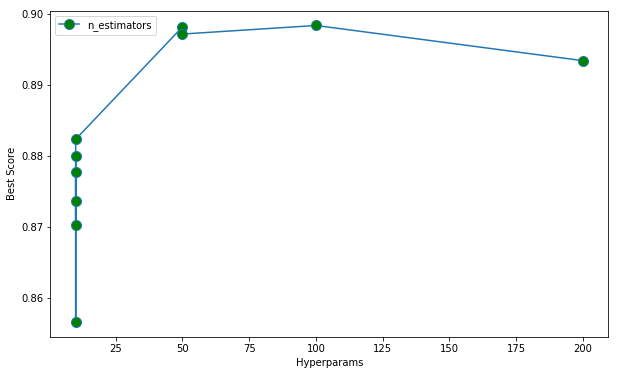

In [119]:
XGB_best_params(bow_X_train, y_train)

accuracy Score = 0.9053
F1 Score = 0.9464739906174048
precision_score = 0.9129834254143646
recall_score = 0.982515157441815


C:\Users\Aravindh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


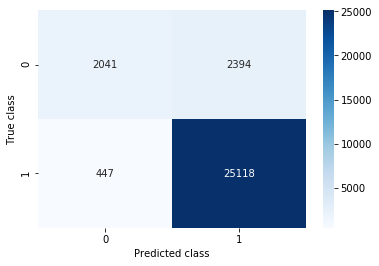

In [120]:
XGB(0.6, 100, 2, bow_X_train, y_train, bow_X_test, y_test)

# TFIDF

In [121]:
vect = TfidfVectorizer()

In [122]:
from sklearn import preprocessing
tfidf_X_train = vect.fit_transform(X_train)
tfidf_X_train = preprocessing.normalize(tfidf_X_train)
tfidf_X_train

<70000x32149 sparse matrix of type '<class 'numpy.float64'>'
	with 2162199 stored elements in Compressed Sparse Row format>

In [123]:
tfidf_X_test = vect.transform(X_test)
tfidf_X_test = preprocessing.normalize(tfidf_X_test)
tfidf_X_test

<30000x32149 sparse matrix of type '<class 'numpy.float64'>'
	with 880827 stored elements in Compressed Sparse Row format>

In [109]:
joblib.dump(tfidf_X_train, 'tfidf_X_train.pkl') 
joblib.dump(tfidf_X_test, 'tfidf_X_test.pkl') 

['tfidf_X_test.pkl']

In [111]:
tfidf_X_train = joblib.load('tfidf_X_train.pkl') 
tfidf_X_test = joblib.load('tfidf_X_test.pkl') 

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


best Accuracy: {'n_estimators': 34, 'max_depth': 39}
best Score: 0.8557598617004558


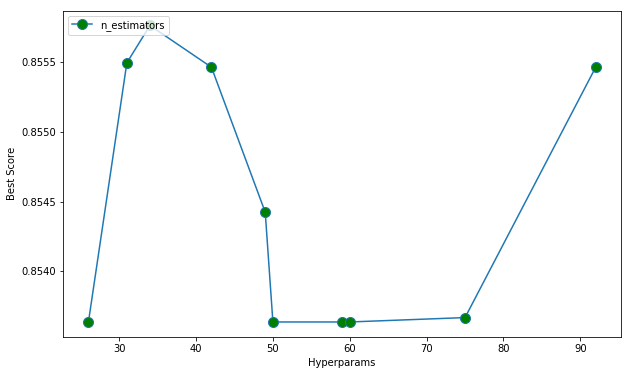

In [124]:
RF_best_params(tfidf_X_train, y_train)

accuracy: 0.8539333333333333
f1_score: 0.9210592686002522
precision_score = 0.853698447153114
recall_score = 0.9999608840211226
Confusion Matrix:


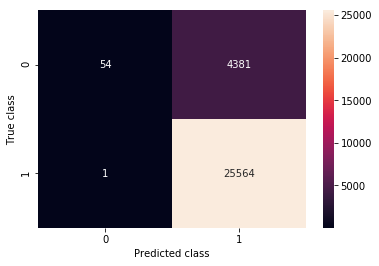

In [125]:
RF(34, 39, tfidf_X_train, y_train, tfidf_X_test, y_test)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished


best Accuracy: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.8}
best Score: 0.9023573785950023


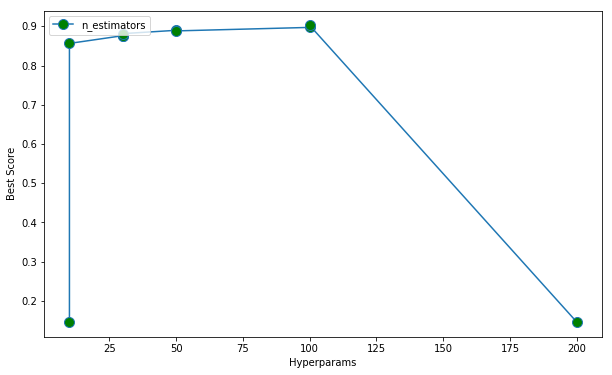

In [126]:
XGB_best_params(tfidf_X_train, y_train)

accuracy Score = 0.9094333333333333
F1 Score = 0.9480745341614907
precision_score = 0.9269058295964125
recall_score = 0.9702327400743204


C:\Users\Aravindh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


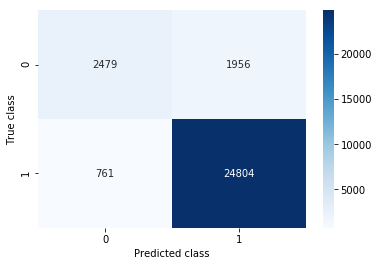

In [127]:
XGB(0.8, 100, 4, tfidf_X_train, y_train, tfidf_X_test, y_test)

# Feature Importance XGboost on TFIDF

In [153]:
clf = XGBClassifier(learning_rate=0.8, n_estimators=100, max_depth=4, njobs=-1)
clf.fit(tfidf_X_train, y_train)
fi = clf.feature_importances_

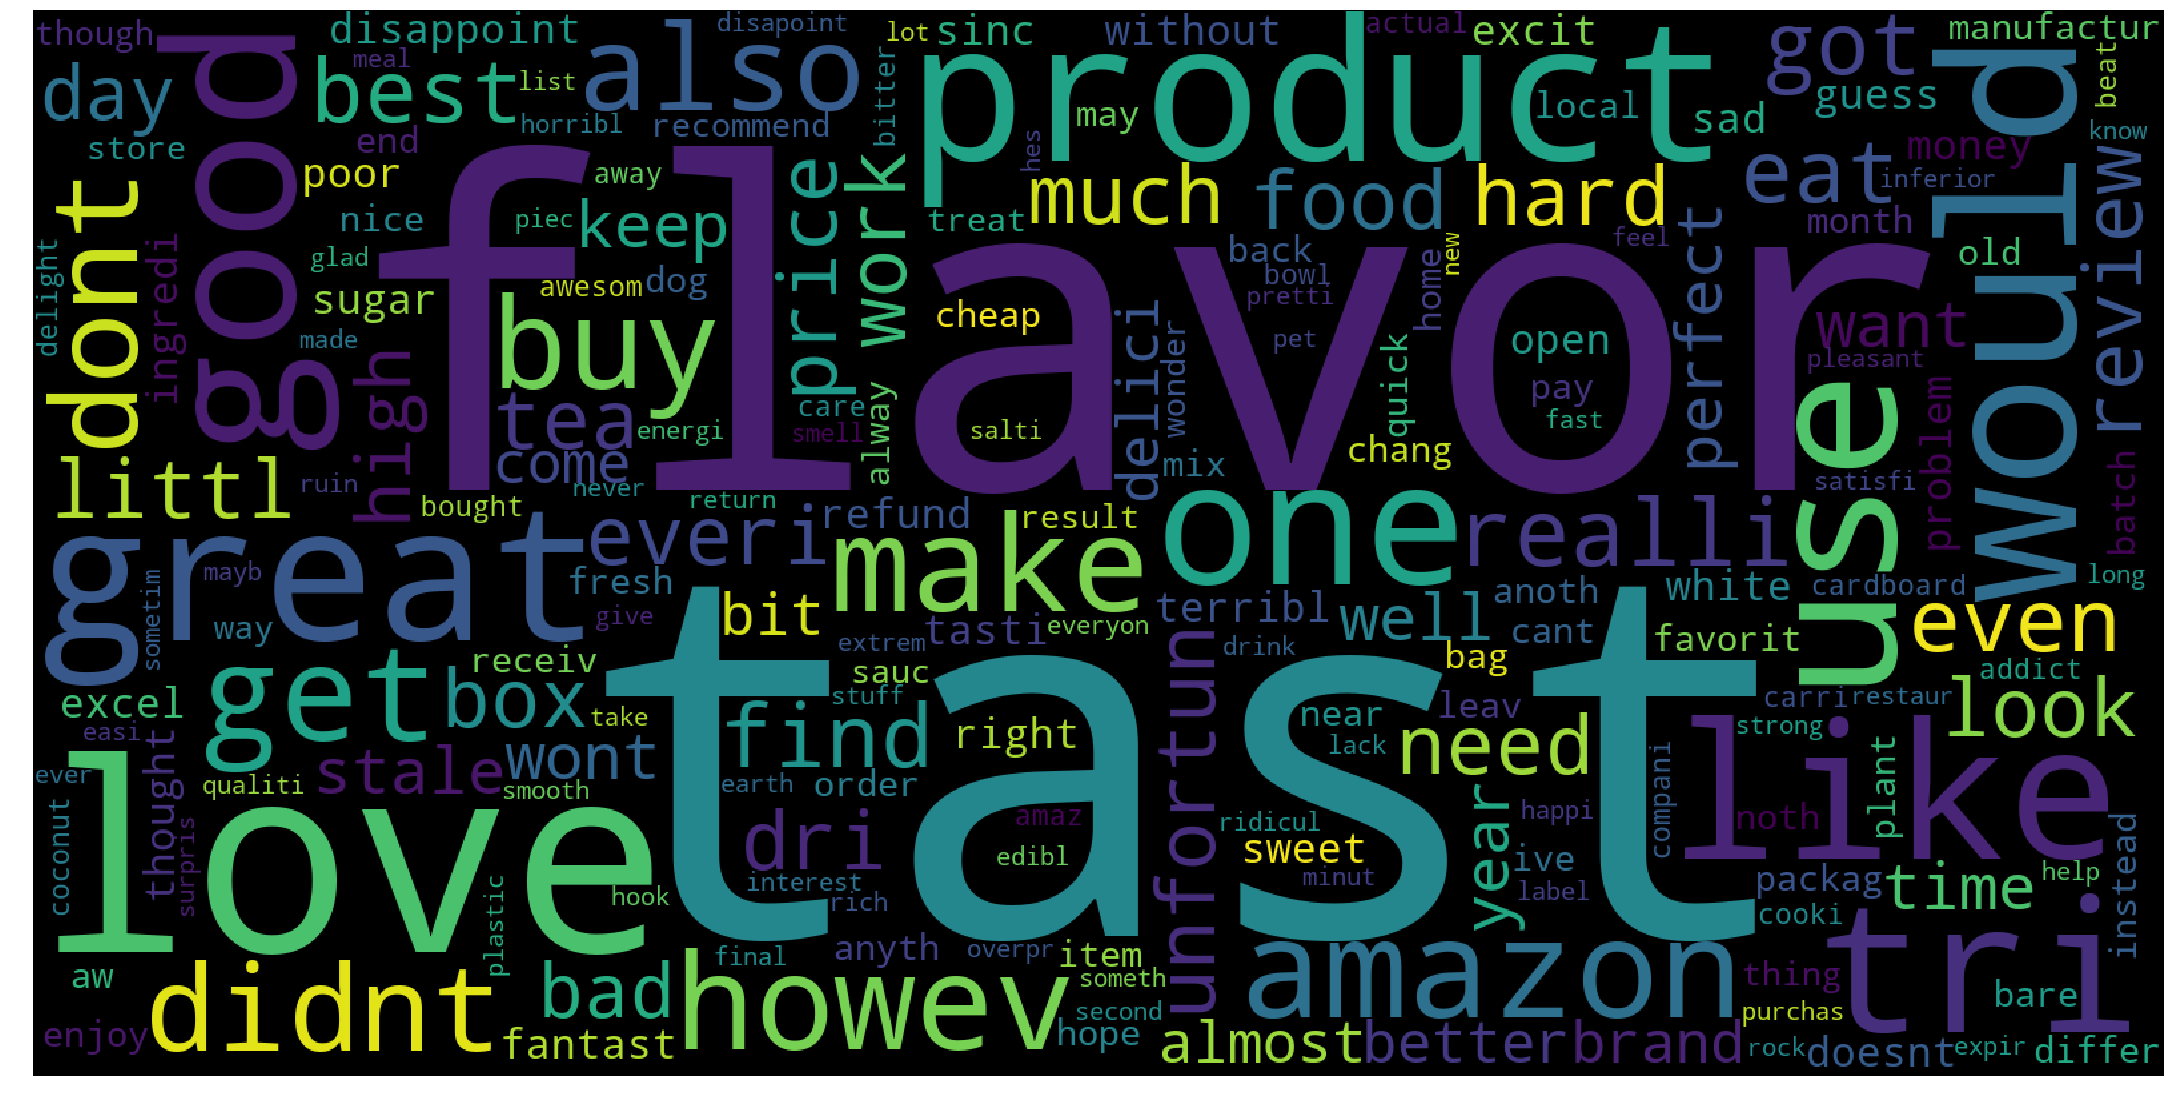

In [154]:
# Ploting word cloud
from wordcloud import WordCloud

freq = fi
words = vect.get_feature_names()
result = dict(zip(words, freq))

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

# Feature Importance Random Forest

In [155]:
clf = RandomForestClassifier(n_estimators = 42 , max_depth = 35, n_jobs=-1)
clf.fit(tfidf_X_train,y_train)
RF_fi = clf.feature_importances_

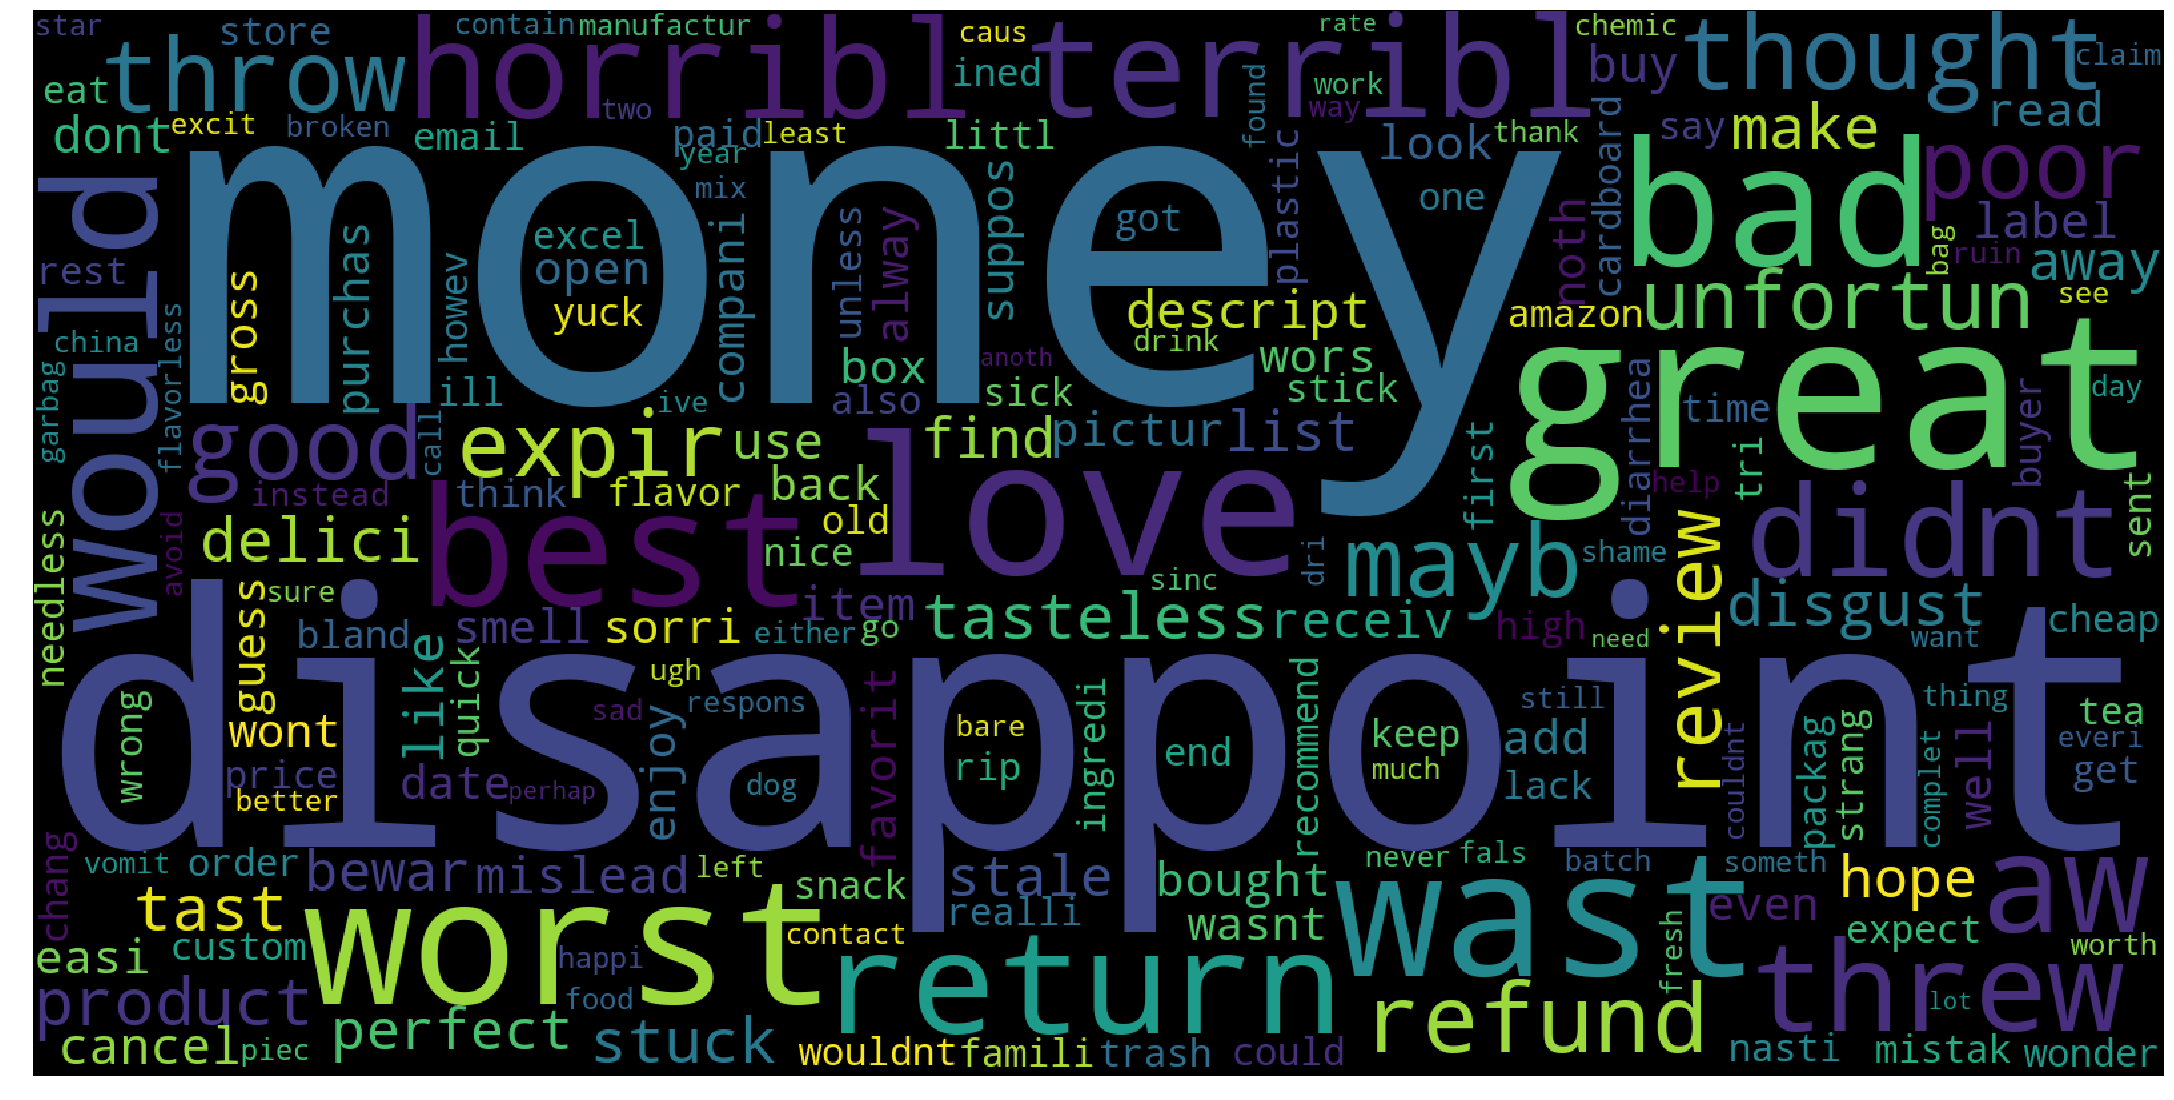

In [157]:
# Ploting word cloud
from wordcloud import WordCloud

freq = RF_fi
words = vect.get_feature_names()
result = dict(zip(words, freq))

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

# RESULTS

In [141]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["MODEL", "Hyperparameters", "ACCURACY", "PRECISION", "RECALL", 'F1-SCORE' ]
#BOW
x.add_row(['Bagging on BOW with Random Forest ', 'n_estimators = 13\n Tree-max_depth = 15', 0.85, 0.92, 0.85, 1.00])
x.add_row(['--'*5,'--'*5,'--'*5,'--'*5, '--'*5, '--'*5])
x.add_row(['GBDT on BOW with XGBOOST', 'n_estimators = 13\n Tree-max_depth = 15\n Learning Rate = 0.6', 0.90, 0.94, 0.91, 0.98])
x.add_row(['--'*5,'--'*5,'--'*5,'--'*5, '--'*5, '--'*5])
#TFIDF
x.add_row(['Bagging on TFIDF with Random Forest', 'n_estimators = 13\n Tree-max_depth = 15', 0.85, 0.92, 0.85, 0.97])
x.add_row(['--'*5,'--'*5,'--'*5,'--'*5, '--'*5, '--'*5])
x.add_row(['GBDT on TFIDF with XGBOOST', 'n_estimators = 13\n Tree-max_depth = 15\n Learning Rate = 0.6', 0.90, 0.94, 0.92, 0.97])
x.add_row(['--'*5,'-'*8,'-'*8,'-'*5, '--'*5, '--'*5])
#AVGW2V
x.add_row(['Bagging on AVGW2V with Random Forest', 'n_estimators = 13\n Tree-max_depth = 15', 0.88, 0.93, 0.89, 0.98])
x.add_row(['--'*5,'--'*5,'--'*5,'--'*5, '--'*5, '--'*5])
x.add_row(['GBDT on AVGW2V with XGBOOST', 'n_estimators = 13\n Tree-max_depth = 15\n Learning Rate = 0.6', 0.89, 0.94, 0.91, 0.96])
x.add_row(['--'*5,'-'*8,'-'*8,'-'*5, '--'*5, '--'*5])
#TFIDFW2V
x.add_row(['Bagging on TFIDFW2V with Random Forest', 'n_estimators = 13\n Tree-max_depth = 15', 0.88, 0.93, 0.88, 0.98])
x.add_row(['--'*5,'--'*5,'--'*5,'--'*5, '--'*5, '--'*5])
x.add_row(['GBDT on TFIDFW2V with XGBOOST', 'n_estimators = 13\n Tree-max_depth = 15\n Learning Rate = 0.6', 0.88, 0.93, 0.89, 0.97])

print(x)

+----------------------------------------+----------------------+------------+------------+------------+------------+
|                 MODEL                  |   Hyperparameters    |  ACCURACY  | PRECISION  |   RECALL   |  F1-SCORE  |
+----------------------------------------+----------------------+------------+------------+------------+------------+
|   Bagging on BOW with Random Forest    |  n_estimators = 13   |    0.85    |    0.92    |    0.85    |    1.0     |
|                                        |  Tree-max_depth = 15 |            |            |            |            |
|               ----------               |      ----------      | ---------- | ---------- | ---------- | ---------- |
|        GBDT on BOW with XGBOOST        |  n_estimators = 13   |    0.9     |    0.94    |    0.91    |    0.98    |
|                                        |  Tree-max_depth = 15 |            |            |            |            |
|                                        |  Learning Rat

In [140]:
#number of positive and negative values in test data
y_test.value_counts()

1    25565
0     4435
Name: Score, dtype: int64

**OBSERVATIONS**

since AVGW2v and TFIDFW2V took too much time for converting to a vector. the total number of datapoints used are limited to 100K. also, the BOW & TFIDF were trained on all data and the confusion matrix and accuracy score were same in percentages.

1. both GridSearchCV() and randomSearchCV() were tried on XGboost and Random Forest, But the Result prediction were almost same. But, Random Searvh was fast. so, RandomizedSearchCV() is used for hyperparameter search.

2. XGBoost performs well on most models, it gives minimum mis-classification on TFIDF max of 2.7k mis-classifications. XGB is in par with logistic regresstion results. so, further optimisations can be done on XGB or Logistic Regression to get best results

3. Random Forest were also better than most of other model as max mis-classification was 3.5k to 4k. RF performed very well on word2vec's.

4. Further Optimisations like Feature Engineerring can be done on XGboost or Logistic Regression Model. Logistic Regression will be most preferred if Low-latency requirement is needed.